# Bonus2: Build a Supervised Autoencoder.

### Name: [Hai Huang]



PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised leanring?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


## 0. You will do the following:

1. Read and run my code to train a standard dense autoencoder.

2. Build and train a supervised autoencoder, visual the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus2/Bonus2.html


## 1. Data preparation

### 1.1. Load data


In [36]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [37]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [38]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
3. Try to achieve a validation loss as low as possible.
4. Evaluate the model on the test set.
5. Visualize the low-dim features and reconstructions.

### 2.1. Build the model

In [39]:
from keras.layers import Dense, Input
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

ae = models.Model(input_img, decode4)

ae.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
_________________________________________________________________
decode1 (Dense)              (None, 8)                 24        
_________________________________________________________________
decode2 (Dense)              (None, 32)                288 

In [40]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters

In [41]:
from keras import optimizers

learning_rate = 1E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))

In [42]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 2s 13ms/step - loss: 0.0853 - val_loss: 0.0789
Epoch 2/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0793 - val_loss: 0.0781
Epoch 3/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0786 - val_loss: 0.0777
Epoch 4/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0776 - val_loss: 0.0753
Epoch 5/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0752 - val_loss: 0.0743
Epoch 6/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0742 - val_loss: 0.0720
Epoch 7/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0723 - val_loss: 0.0709
Epoch 8/100
79/79 [==============================] - 1s 10ms/step - loss: 0.0707 - val_loss: 0.0697
Epoch 9/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0696 - val_loss: 0.0688
Epoch 10/100
79/79 [==============================] - 1s 11ms/step - loss: 0.0691 - val_loss: 0.0682

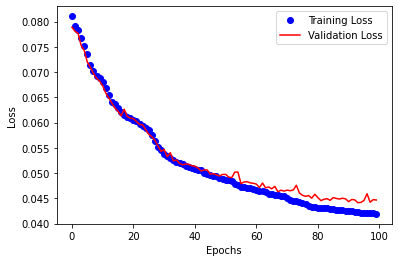

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images

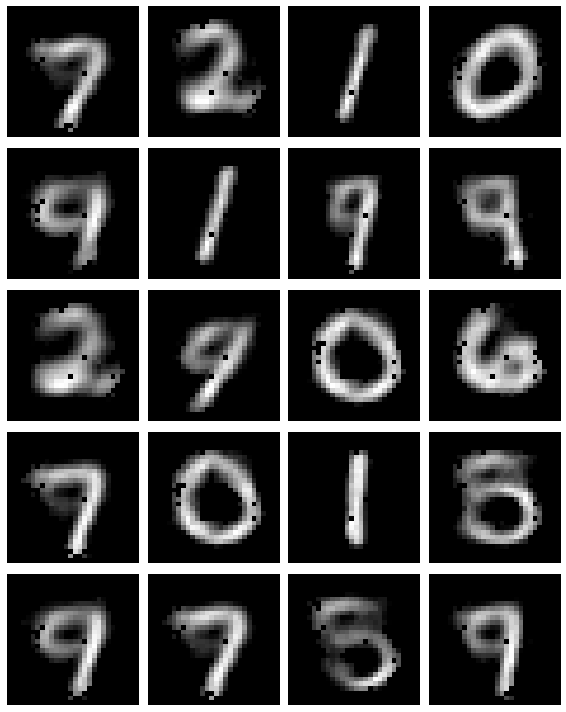

In [44]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [45]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 [==============================] - 1s 2ms/step - loss: 0.0449
loss = 0.04489348083734512


### 2.5. Visualize the low-dimensional features

In [46]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


In [47]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


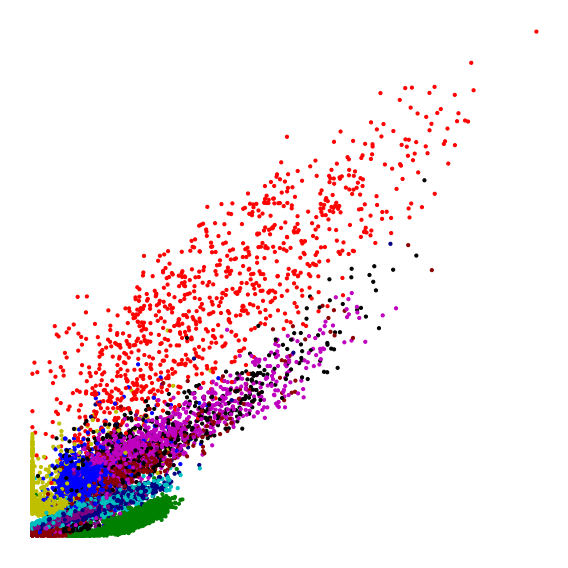

In [48]:
colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [49]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [50]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [51]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 1s 3ms/step - loss: 2.1589 - acc: 0.2028 - val_loss: 1.7798 - val_acc: 0.2821
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss: 1.7240 - acc: 0.3198 - val_loss: 1.6194 - val_acc: 0.3833
Epoch 3/30
313/313 [==============================] - 1s 2ms/step - loss: 1.6145 - acc: 0.4061 - val_loss: 1.5250 - val_acc: 0.4484
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 1.5153 - acc: 0.4653 - val_loss: 1.4548 - val_acc: 0.4985
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 1.4410 - acc: 0.5274 - val_loss: 1.3935 - val_acc: 0.5583
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 1.3848 - acc: 0.5619 - val_loss: 1.3392 - val_acc: 0.5833
Epoch 7/30
313/313 [==============================] - 1s 2ms/step - loss: 1.3201 - acc: 0.5926 - val_loss: 1.2874 - val_acc: 0.5959
Epoch 8/30
313/313 [==============================] - 1s 2ms/step - loss: 1.

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 98%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network

In [71]:
# build the supervised autoencoder network
from keras import models, regularizers
from keras.layers import Dense, Input

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)

# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)

# decoder network
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

# build a classifier upon the bottleneck layer
classifier1 = Dense(130, activation='softmax',name='classifier1',kernel_regularizer=regularizers.l2(l=0.01))(bottleneck)
classifier2 = Dense(34, activation='softmax',name='classifier2',kernel_regularizer=regularizers.l2(l=0.01))(classifier1)
classifier3 = Dense(10, activation='softmax',name='classifier3',kernel_regularizer=regularizers.l2(l=0.01))(classifier2)

In [72]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
encode1 (Dense)                 (None, 128)          100480      input_img[0][0]                  
__________________________________________________________________________________________________
encode2 (Dense)                 (None, 32)           4128        encode1[0][0]                    
__________________________________________________________________________________________________
encode3 (Dense)                 (None, 8)            264         encode2[0][0]                    
___________________________________________________________________________________________

In [73]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [74]:
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 4s 8ms/step - loss: 1.5323 - decode4_loss: 0.0872 - classifier3_loss: 2.3027 - val_loss: 1.2338 - val_decode4_loss: 0.0816 - val_classifier3_loss: 2.3016
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 1.2323 - decode4_loss: 0.0811 - classifier3_loss: 2.3015 - val_loss: 1.2273 - val_decode4_loss: 0.0765 - val_classifier3_loss: 2.3015
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 1.2258 - decode4_loss: 0.0754 - classifier3_loss: 2.3008 - val_loss: 1.2237 - val_decode4_loss: 0.0730 - val_classifier3_loss: 2.3013
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 1.2245 - decode4_loss: 0.0733 - classifier3_loss: 2.3022 - val_loss: 1.2213 - val_decode4_loss: 0.0706 - val_classifier3_loss: 2.3013
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 1.2207 - decode4_loss: 0.0702 - classifier3_loss: 2.3009 - val_loss: 1.2175 - val_decode4

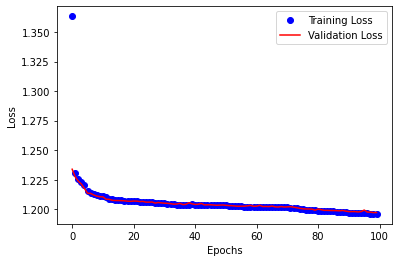

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

**Failing to add proper regularization will lose 1~2 scores.**

### 4.3. Visualize the reconstructed test images

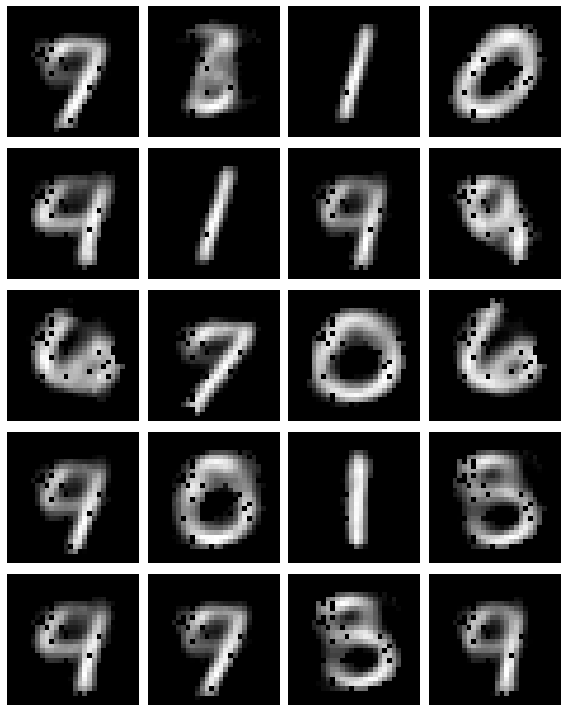

In [76]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features

In [77]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


Shape of encoded_test: (10000, 2)


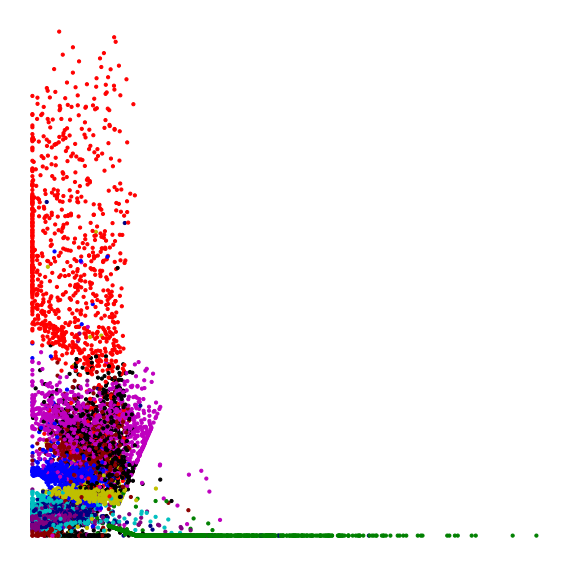

In [78]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.


In [79]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [83]:
# build a classifier which takes the 2D features as input
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [84]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 1s 3ms/step - loss: 2.1368 - acc: 0.1531 - val_loss: 1.9609 - val_acc: 0.2350
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss: 1.9279 - acc: 0.2644 - val_loss: 1.7834 - val_acc: 0.3845
Epoch 3/30
313/313 [==============================] - 1s 2ms/step - loss: 1.7641 - acc: 0.4039 - val_loss: 1.6590 - val_acc: 0.4349
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 1.6566 - acc: 0.4458 - val_loss: 1.5678 - val_acc: 0.4591
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 1.5742 - acc: 0.4773 - val_loss: 1.5020 - val_acc: 0.5163
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 1.5481 - acc: 0.5104 - val_loss: 1.4504 - val_acc: 0.5391
Epoch 7/30
313/313 [==============================] - 1s 2ms/step - loss: 1.4718 - acc: 0.5383 - val_loss: 1.4094 - val_acc: 0.5383
Epoch 8/30
313/313 [==============================] - 1s 2ms/step - loss: 1.

#### Remark:

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [108]:
# evaluate your model on the never-seen-before test data
# write your code here:
loss = sae.evaluate(x_test, [x_test,y_test_vec])
print('loss = ' + str(loss))

313/313 [==============================] - 1s 2ms/step - loss: 1.1973 - decode4_loss: 0.0463 - classifier3_loss: 2.3018
loss = [1.1972901821136475, 0.04630870744585991, 2.301818609237671]
